In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import wandb



wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
wandb.init(project="chest-xray")

wandb: Currently logged in as: stura36 (lopital). Use `wandb login --relogin` to force relogin


In [4]:
pd.read_csv("../input/data/Data_Entry_2017.csv")

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


In [5]:
df_data_entry = pd.read_csv("../input/data/Data_Entry_2017.csv")
df_bbox = pd.read_csv("../input/data/BBox_List_2017.csv")


In [6]:
df_data_entry.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


## Preparing tabular data

In [7]:
from glob import glob


df_data_entry.drop(labels=["Unnamed: 11"], inplace=True, axis=1)

df_data_entry.rename(columns={"Image Index": "idx", "Finding Labels": "labels", "Follow-up #" : "follow-up",
                              "Patient ID" : "p_id", "Patient Age": "p_age", "Patient Gender": "p_gender",
                              "View Position" : "xray_orientation", "OriginalImage[Width" : "org_img_w", "Height]" : "org_img_h"
                              , "OriginalImagePixelSpacing[x" : "pixel_spacing_x", "y]" : "pixel_spacing_y"}, inplace=True)

target_cols = list()
for i, labels in enumerate(df_data_entry["labels"]):
    ys = labels.split("|")
    for y in ys:
        target_cols.append(y)
        df_data_entry.at[i, y] = 1

target_cols = list(set(target_cols))

df_data_entry.fillna(0, inplace=True)
df_data_entry.drop(labels=["labels"], axis=1, inplace=True)



final_dataset = df_data_entry.drop(["follow-up", "p_id", "org_img_w", "org_img_h", "pixel_spacing_x", "pixel_spacing_y"], axis=1)

final_dataset['p_gender'].replace(["F","M"],[0,1],inplace=True)
final_dataset['xray_orientation'].replace(['AP','PA'], [0,1],inplace=True)

final_dataset = final_dataset[final_dataset["p_age"] <= 95]



all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input','chest-xray-256x256','chestxray256x256', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', final_dataset.shape[0])
final_dataset['path'] = final_dataset['idx'].map(all_image_paths.get)

final_dataset['p_age_norm'] = (final_dataset['p_age'] - final_dataset['p_age'].min()) / (final_dataset['p_age'].max() - final_dataset['p_age'].min())


Scans found: 112120 , Total Headers 112104


In [8]:
final_dataset_classification = final_dataset[final_dataset["No Finding"] == 0]
outputs_classification = ["Cardiomegaly" ,"Emphysema" ,"Effusion" ,"Hernia" ,"Infiltration" ,"Mass" ,"Nodule" ,"Atelectasis","Pneumothorax" ,"Pleural_Thickening" ,"Pneumonia" ,"Fibrosis","Edema" ,"Consolidation"]
final_dataset_classification.drop(["No Finding"],inplace = True,axis = 1)
final_dataset_classification.reset_index(drop = True)


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,idx,p_age,p_gender,xray_orientation,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,path,p_age_norm
0,00000001_000.png,58,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/chest-xray-256x256/chestxray256x256/0...,0.606383
1,00000001_001.png,58,1,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/chest-xray-256x256/chestxray256x256/0...,0.606383
2,00000001_002.png,58,1,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/chest-xray-256x256/chestxray256x256/0...,0.606383
3,00000003_000.png,81,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/chest-xray-256x256/chestxray256x256/0...,0.851064
4,00000003_001.png,74,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/chest-xray-256x256/chestxray256x256/0...,0.776596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51746,00030786_007.png,61,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,../input/chest-xray-256x256/chestxray256x256/0...,0.638298
51747,00030789_000.png,52,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/chest-xray-256x256/chestxray256x256/0...,0.542553
51748,00030793_000.png,58,0,1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/chest-xray-256x256/chestxray256x256/0...,0.606383
51749,00030795_000.png,53,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,../input/chest-xray-256x256/chestxray256x256/0...,0.553191


In [9]:
final_dataset_presence = final_dataset.drop(outputs_classification, axis = 1)
final_dataset_presence.reset_index(drop = True)
outputs_presence = ["No Finding"]

In [10]:
final_dataset.head()

,idx,p_age,p_gender,xray_orientation,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,...,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation,path,p_age_norm
0,00000001_000.png,58,1,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/chest-xray-256x256/chestxray256x256/0...,0.606383
1,00000001_001.png,58,1,1,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/chest-xray-256x256/chestxray256x256/0...,0.606383
2,00000001_002.png,58,1,1,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/chest-xray-256x256/chestxray256x256/0...,0.606383
3,00000002_000.png,81,1,1,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/chest-xray-256x256/chestxray256x256/0...,0.851064
4,00000003_000.png,81,0,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/chest-xray-256x256/chestxray256x256/0...,0.851064


In [11]:
print(final_dataset[final_dataset["No Finding"]== 1].shape)
print(final_dataset[final_dataset["No Finding"]== 0].shape)

(60353, 21)
(51751, 21)


In [12]:
import torch
import torchvision.transforms as transforms

class CSVDataset(torch.utils.data.Dataset):
    def __init__(self, df,kwargs,y_cols):
        self.image_paths = df['path'].tolist()
        self.multi_input = False
        self.labels = df[y_cols].values.tolist()
        
        normalize_fun = lambda x: x/255.
        transforms_list = [transforms.ToTensor(),normalize_fun]
        
        
        if kwargs["multi_input"]:
            self.multi_input = True
            self.p_ages = df['p_age_norm'].tolist()
            self.p_genders = df['p_gender'].tolist()
            self.xray_orientations = df['xray_orientation'].tolist()
            
        if kwargs["grayscale"]:
            transforms_list.insert(0,transforms.Grayscale())
            
        if kwargs["preprocess"]:
            transforms_list.remove(normalize_fun)
            transforms_list.insert(0,kwargs["preprocess"])
            
            
        self.transform = transforms.Compose(transforms_list)
                        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load and preprocess the image
        image = Image.open(self.image_paths[idx])
        image = self.transform(image)
        labels = torch.tensor(self.labels[idx])
        
        if self.multi_input:
            return image, self.p_ages[idx], self.p_genders[idx], self.xray_orientations[idx], labels
        
        return image, labels


In [13]:
import cv2
import PIL
def custom_threshold(img):
    return np.min(img) + 0.9 * (np.max(img) - np.min(img))

def preprocess_paper(test_img):
    test_img_resize = np.array(test_img)
    gray_img = cv2.cvtColor(test_img_resize, cv2.COLOR_BGR2GRAY)
    equ = cv2.equalizeHist(gray_img)
    _,thresh1 = cv2.threshold(equ,custom_threshold(equ),255,cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(thresh1,cv2.MORPH_CLOSE, kernel, iterations=1)
    Ip = cv2.bitwise_and(gray_img,gray_img,mask = 255-closing)
    Ib = cv2.bilateralFilter(Ip, d=5, sigmaColor=75, sigmaSpace=75)
    Ieq = cv2.equalizeHist(Ip)
    rgb = np.dstack((Ieq,Ip,Ib))
    return rgb

In [14]:


LEARNING_RATE = 0.00001
NUM_EPOCHS = 5
BATCH_SIZE = 32
THRESHOLD = 0.5

wandb.config = {
  "learning_rate": LEARNING_RATE ,
  "epochs": NUM_EPOCHS,
  "batch_size": BATCH_SIZE,
"threshold": THRESHOLD
}

In [15]:
import torch.optim as optim
from tqdm import trange
import torchvision.models as models
from torchmetrics.classification import MultilabelF1Score, MultilabelPrecision, MultilabelRecall, MultilabelAccuracy
from torchmetrics.classification import BinaryF1Score,BinaryPrecision,BinaryRecall,BinaryAccuracy
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




def setup_metrics_dataset(model):
    accuracy_torch = None
    precision_torch = None
    recall_torch = None
    f1_torch = None
    dataset = None
    
    if(model.model_info["task"] =="presence"):
        accuracy_torch = BinaryAccuracy().to(device)
        precision_torch = BinaryPrecision().to(device)
        recall_torch = BinaryRecall().to(device)
        f1_torch = BinaryF1Score().to(device)
        
        dataset = CSVDataset(final_dataset_presence, model.model_info, outputs_presence)


    else:
        accuracy_torch = MultilabelAccuracy(num_labels=14).to(device)
        precision_torch = MultilabelPrecision(num_labels=14).to(device)
        recall_torch = MultilabelRecall(num_labels=14).to(device)
        f1_torch = MultilabelF1Score(num_labels=14).to(device)
        
        dataset = CSVDataset(final_dataset_classification, model.model_info,outputs_classification)


    return accuracy_torch,precision_torch,recall_torch,f1_torch,dataset

In [16]:





# Define the model and the criterion

model_vgg16 = models.vgg16(pretrained=True)
model_vgg16.classifier[0] = nn.Linear(in_features=25088, out_features=256)
model_vgg16.classifier[3] = nn.Linear(in_features=256, out_features=128)
model_vgg16.classifier[-1] = nn.Linear(in_features=128, out_features=1)


model_vgg16.model_info = {
            "multi_input" : False,
            "grayscale" : False,
            "preprocess": preprocess_paper,
            "task": "presence"
       }

for param in model_vgg16.features.parameters():
    param.requires_grad=True
    
    
    
model = model_vgg16.to(device)

    
accuracy_torch,precision_torch,recall_torch,f1_torch,dataset = setup_metrics_dataset(model)
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Create the dataset

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [78474, 22420, 11210]) #70%, 20%, 10%

# Define the optimizer

# Create the data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
print(len(train_data_loader), len(val_data_loader), len(test_data_loader))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

2453 22420 11210


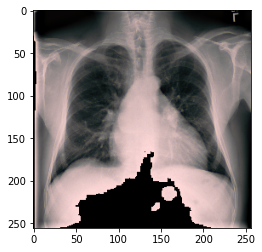

In [17]:
#TEST BLOCK JUST TO MAKE SURE IT WORKS
import matplotlib.pyplot as plt
plt.imshow(dataset.__getitem__(0)[0].permute(1, 2, 0))

In [18]:
from time import sleep
from tqdm import tqdm

SAVE_PATH = "/kaggle/working/model_paper_"
model_paper = model
for epoch in range(NUM_EPOCHS):
    #TRAINING STEP
    model_paper.train()
    with tqdm(train_data_loader, unit="batch") as tepoch:
        for i_iter, (images, labels) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch}")

            
            #SENDING DATA TO GPU
            images, labels = images.to(device), labels.to(device)
            
            #FORWARD PASS
            optimizer.zero_grad()
            output = model_paper(images)
            loss = criterion(output, labels)
            
            #EVALUATION
            sigmoid_output = torch.sigmoid(output)
            y_pred = torch.where(sigmoid_output >= THRESHOLD, 1, 0)
            
            #METRICS
            wandb.log({"loss": loss,
                       "accuracy":accuracy_torch(y_pred, labels).item(),
                       "precision":precision_torch(y_pred, labels).item(),
                       "recall":recall_torch(y_pred, labels).item(),
                       "f1": f1_torch(y_pred, labels).item()
                      })
            
            #TRAINING PROGRESS VISUALIZATION
            tepoch.set_postfix(loss=loss.item(),
                               acc_torch=100*accuracy_torch(y_pred, labels).item(),
                               prec_torch=100*precision_torch(y_pred, labels).item(),
                               rec_torch=100*recall_torch(y_pred, labels).item(),
                               f1m_torch=100*f1_torch(y_pred, labels).item()
                              )
            
            #BACKWARD PASS
            loss.backward()
            optimizer.step()
            
    #EVALUATION STEP        
    model_paper.eval()
    
    
    
    y_preds_val = []
    labels_val = []
    for images, labels in val_data_loader:

        #SENDING DATA TO GPU
        images, labels = images.to(device), labels.to(device)

        #FORWARD PASS
        output = model_paper(images)

        #EVALUATION
        sigmoid_output = torch.sigmoid(output)
        y_pred = torch.where(sigmoid_output >= THRESHOLD, 1, 0)
        
        y_preds_val.append(y_pred.item())
        labels_val.append(labels.item())
        #METRICS
    y_preds_val = torch.Tensor(y_preds_val).to(device)
    labels_val = torch.Tensor(labels_val).to(device)
    
    loss = criterion(y_preds_val,labels_val)    
    accuracy = accuracy_torch(y_preds_val, labels_val)
    precision = precision_torch(y_preds_val, labels_val)
    f1 = f1_torch(y_preds_val, labels_val)
    recall = recall_torch(y_preds_val, labels_val)
    
        
    #CALCULATE THE AVERAGE METRICS
    
    wandb.log({"loss_val": loss.item(),
               "accuracy_val":accuracy.item(),
               "precision_val":precision.item(),
               "recall_val":recall.item(),
               "f1_val": f1.item()
              })
    
    print(f'Loss on validation set: {loss:.4f}')
    print(f'Accuracy on validation set: {accuracy.item():.4f}')
    print(f'Precision on validation set: {precision.item():.4f}')
    print(f'Recall on validation set: {recall.item():.4f}')
    print(f'F1 score on validation set: {f1.item():.4f}')
    
    #SAVE THE MODEL AT THE END OF EACH EPOCH
    torch.save(model_paper.state_dict(), SAVE_PATH + str(epoch) + ".pth")

Epoch 0: 100%|██████████| 2453/2453 [19:37<00:00,  2.08batch/s, acc_torch=50, f1m_torch=44.4, loss=0.847, prec_torch=40, rec_torch=50]      


Loss on validation set: 0.6461
Accuracy on validation set: 0.6985
Precision on validation set: 0.6965
Recall on validation set: 0.7894
F1 score on validation set: 0.7401


Epoch 1: 100%|██████████| 2453/2453 [19:27<00:00,  2.10batch/s, acc_torch=80, f1m_torch=80, loss=0.608, prec_torch=80, rec_torch=80]        


Loss on validation set: 0.6361
Accuracy on validation set: 0.7072
Precision on validation set: 0.7201
Recall on validation set: 0.7551
F1 score on validation set: 0.7372


Epoch 2: 100%|██████████| 2453/2453 [19:27<00:00,  2.10batch/s, acc_torch=70, f1m_torch=76.9, loss=0.547, prec_torch=71.4, rec_torch=83.3]  


Loss on validation set: 0.6291
Accuracy on validation set: 0.7104
Precision on validation set: 0.7420
Recall on validation set: 0.7165
F1 score on validation set: 0.7290


Epoch 3: 100%|██████████| 2453/2453 [19:26<00:00,  2.10batch/s, acc_torch=70, f1m_torch=57.1, loss=0.437, prec_torch=50, rec_torch=66.7]    


Loss on validation set: 0.6330
Accuracy on validation set: 0.7107
Precision on validation set: 0.7278
Recall on validation set: 0.7476
F1 score on validation set: 0.7376


Epoch 4: 100%|██████████| 2453/2453 [19:27<00:00,  2.10batch/s, acc_torch=60, f1m_torch=50, loss=0.646, prec_torch=40, rec_torch=66.7]      


Loss on validation set: 0.6368
Accuracy on validation set: 0.7050
Precision on validation set: 0.7196
Recall on validation set: 0.7495
F1 score on validation set: 0.7342


In [19]:
!zip -r file.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/wandb/ (stored 0%)
  adding: kaggle/working/wandb/latest-run/ (stored 0%)
  adding: kaggle/working/wandb/latest-run/files/ (stored 0%)
  adding: kaggle/working/wandb/latest-run/files/requirements.txt (deflated 57%)
  adding: kaggle/working/wandb/latest-run/files/wandb-summary.json (deflated 45%)
  adding: kaggle/working/wandb/latest-run/files/wandb-metadata.json (deflated 42%)
  adding: kaggle/working/wandb/latest-run/files/config.yaml (deflated 45%)
  adding: kaggle/working/wandb/latest-run/files/conda-environment.yaml (deflated 65%)
  adding: kaggle/working/wandb/latest-run/files/output.log (deflated 85%)
  adding: kaggle/working/wandb/latest-run/logs/ (stored 0%)
  adding: kaggle/working/wandb/latest-run/logs/debug-internal.log (deflated 96%)
  adding: kaggle/working/wandb/latest-run/logs/debug.log (deflated 84%)
  adding: kaggle/working/wandb/latest-run/run-9oqvxfc8.wandb (deflated 80%)
  adding: kaggle/working/wandb/la

## Not used

In [20]:
#METRICS FUNCTIONS

def micro(tp,fp,fn):
    precision = tp.sum() / (tp.sum() + fp.sum()+1e-09)
    recall = tp.sum() / (tp.sum() + fn.sum()+1e-09)
    
    f1 = precision * recall / (precision + recall + 1e-09)
    return precision,recall,f1

def macro(tp,fp,fn):    
    precision = (tp/(tp+fp+1e-09)).mean()
    recall = (tp/(tp+fn+1e-09)).mean()
    
    f1 = precision * recall / (precision + recall + 1e-09)
    return precision,recall,f1


In [21]:

class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.conv11 = nn.Conv2d(1, 32, 4)
        self.mp11 = nn.MaxPool2d(2, 2)
        self.conv12 = nn.Conv2d(32, 16, 3)
        self.mp12 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(3, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(61536, 100)  # The input size of this layer should be adjusted based on the output size of the Flatten layer
        self.linear4 = nn.Linear(100, 1)
        
        self.model_info = {
            "multi_input" : True,
            "grayscale" : True,
            "preprocess": None
        }
        
    def forward(self, x1, x2):
        x1 = self.conv11(x1)
        x1 = self.mp11(x1)
        x1 = self.conv12(x1)
        x1 = self.mp12(x1)
        x1 = self.flatten(x1)
        x2 = self.linear1(x2.to(torch.float32))
        x2 = self.relu(x2)
        x2 = self.linear2(x2)
        x2 = self.relu(x2)
        x = torch.cat((x1, x2), dim=1)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        return x
    
class BaselinePresence(nn.Module):
    def __init__(self,preprocess = None):
        super(BaselinePresence,self).__init__()
        self.conv1 = nn.Conv2d(3,64,3)
        #relu
        self.mp1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64,64,3)
        #relu
        self.mp2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64,128,3)
        #relu
        self.mp3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128,128,3)
        #relu
        self.mp4 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.drop = nn.Dropout()
        self.linear1 = nn.Linear(25088,512)
        #relu
        self.linear2 = nn.Linear(512,1)
        #sigmoid

        self.model_info = {
            "multi_input" : False,
            "grayscale" : False,
            "preprocess": preprocess,
            "task": "presence"
        }
        
        
    def forward(self,x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.mp1(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.mp2(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.mp3(x)
        x = self.conv4(x)
        x = torch.relu(x)
        x = self.mp4(x)
        x = self.flatten(x)
        x = self.drop(x)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        #sigmoid is applied in the train loop             
        return x
    
    